In [1]:
using BandedMatrices, LinearAlgebra, SparseArrays, IntervalArithmetic, Serialization, LazyArrays

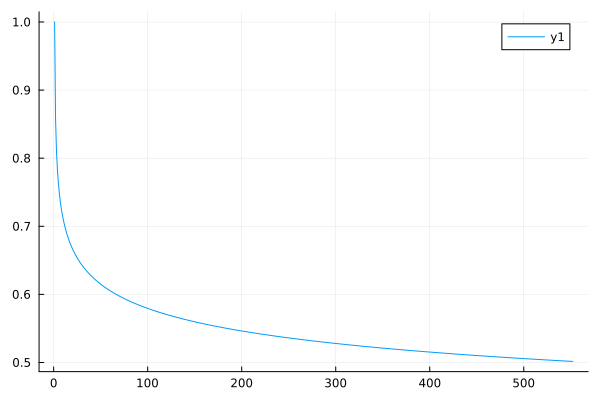

In [4]:
using Plots
plot(inf.(deserialize("pendulum_sups")))

In [ ]:
Base.:*(A::SparseMatrixCSC{Interval{Float64}, Int64},x::Vector{Interval{Float64}})=Vector((A*sparse(x[:,:]))[:])

In [ ]:
γ = interval(0.25)
κ = interval(Float64, 2//3)
σ = interval(4)

In [ ]:
function D(N)
    # implements ∂ₓ in Fourier
    v = interval.([ ((n+1 ) % 2) * (n÷2) for n=1:2*N])
    return dropzeros(sparse(BandedMatrix(-1 => v, 1 =>-v)))
end

function D2(N)
    # implements ∂ₓₓ in Fourier
    v = interval.([-(n÷2)^2 for n=1:2*N+1])
    return dropzeros(sparse(BandedMatrix( 0 => vcat(v, zeros(Interval{Float64}, 2)))[:,1:2*N+1]))
end

function id(N)
    v = ones(Interval{Float64}, 2*N+1)
    return dropzeros(sparse(BandedMatrix( 0 => v)))
end

function id2(N)
    v = ones(Interval{Float64}, 2*N+1)
    return dropzeros(sparse(BandedMatrix( 0 => vcat(v, zeros(Interval{Float64}, 2)))[:,1:2*N+1]))
end

function idZ(N)
    v = ones(Interval{Float64}, N+1)
    return dropzeros(sparse(BandedMatrix( 0 => v)))
end

function idZ2(N)
    v = ones(Interval{Float64}, N+2)
    return dropzeros(sparse(BandedMatrix( 0 => v)))[:,1:N+1]
end

function C(N)
    # implements u ↦ cosx u in Fourier
    v = vcat([interval(0.0)], ones(Interval{Float64}, 2*N)/interval(2))
    A = dropzeros(sparse(BandedMatrix( -2 => v, 2 => v[1:end-2])[:,1:2*N+1]))
    A[1,3] = interval(0.5)
    A[3,1] = interval(1.0)
    return A
end

function S(N)
    # implements u ↦ sinx u in Fourier
    v = vcat([interval(0.0)],interval.([ ((n+1 ) % 2) for n=1:2*N]))/interval(2)
    A = dropzeros(sparse(BandedMatrix( -1 => v[1:end], -3 =>-v[2:end], 1 => v, 3=>-v[2:end])[:,1:2*N+1]))
    A[1,2] = interval(0.5)
    A[2,1] = interval(1.0)
    return A
end

function DZ(N)
    # implements ∂ₓ in Hermite
    v = sqrt(γ)*sqrt.(interval(2)*interval.(1:N+1))/σ
    A = dropzeros(sparse(BandedMatrix(0=>zeros(Interval{Float64}, N+1), 1=>v))[:,1:N+1])
    return A
end

function L(N)
    # implements the generator of the OU process in Hermite
    v = -γ*interval(0:N+1)
    return dropzeros(sparse(Diagonal(v)[:,1:N+1]))
end

function Z(N)
    # implements u ↦ xu in Hermite
    v = σ*sqrt.(interval.(1:N+1)/interval(2))/sqrt(γ)
    return A = dropzeros(sparse(BandedMatrix(0=>zeros(Interval{Float64}, N), -1=>v, 1=>v[1:N])))[:,1:N+1]
end


In [ ]:
K = 500
N = 200
M = 525;
cols = vec([n%2 == m%2 for m=0:M, n=0:2*N, k=0:2*K ])
cols[1] = 0;

In [ ]:
𝔏 = kron(id2(K), id2(N)*D(N), Z(M))[:,cols];
GC.gc()

In [ ]:
𝔏 += kron(id2(K), id2(N), L(M))[:,cols]
GC.gc()
𝔏 -= kron(id2(K), κ*S(N),DZ(M))[:,cols];
GC.gc()

In [ ]:
𝔏 -= kron((id2(K) + γ*S(K) - C(K))*D(K), id2(N), idZ2(M))[:,cols]
GC.gc()
𝔏 -= kron(κ*(id2(K)+C(K))*D(K), C(N), idZ2(M))[:,cols];
GC.gc()

In [ ]:
ū = interval.(deserialize("ubar"));

In [ ]:
Q = Vector(Kron(γ*(C(K)-id2(K)) + S(K), id2(N), idZ2(M))[:,1] - κ*Kron(S(K), C(N), idZ2(M))[:,1])/interval(2)
GC.gc()

In [ ]:
ϵ = 𝔏*ū - Q
λ̄ = -ϵ[1]
ϵ[1] = interval(0);

In [ ]:
suppsi = deserialize("pendulum_sups")[1:M+2];

In [ ]:
μW = deserialize("pendulum_Lyapunov_bound")

In [ ]:
start = 1
finish = M+2
δ = interval(0)
for i=1:(2*K+3)*(2*N+3)
    δ += sum(abs.(ϵ[start:finish]).*suppsi)
    start += M+2
    finish += M+2
end
δ *= μW
λ = λ̄ + interval(-1,1)*δ